# Model Training

We use VAE to train our model. We then visualize it on the trained latent space.

In [1]:
#VAE code from PyTorch Tutorial

from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid

In [2]:
epochs = 10

parser = argparse.ArgumentParser(description='VAE MNIST Example')


device = torch.device("cpu")

kwargs = {'num_workers': 1, 'pin_memory': True} 
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=512, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.ToTensor()),
    batch_size=512, shuffle=True, **kwargs)


class VAE(nn.Module):
    def __init__(self, n_dim):
        super(VAE, self).__init__()
        
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, n_dim) # dimension of latent sapce = 10
        self.fc22 = nn.Linear(400, n_dim)
        self.fc3 = nn.Linear(n_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mu)

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

N_DIM_LATENT = 100
model = VAE(N_DIM_LATENT).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD


def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % 10 == 0:
            '''
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

            '''
    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    #print('====> Test set loss: {:.4f}'.format(test_loss))

if __name__ == "__main__":
    for epoch in range(1, epochs + 1):
        train(epoch)
        test(epoch)
        with torch.no_grad():
            sample = torch.randn(64, N_DIM_LATENT).to(device)
            sample = model.decode(sample).cpu()
            #save_image(sample.view(64, 1, 28, 28),'cur_result/sample_' + str(epoch) + '.png')

====> Epoch: 1 Average loss: 224.8186
====> Epoch: 2 Average loss: 161.0515
====> Epoch: 3 Average loss: 143.4408
====> Epoch: 4 Average loss: 134.3059
====> Epoch: 5 Average loss: 127.7937
====> Epoch: 6 Average loss: 122.7975
====> Epoch: 7 Average loss: 119.0397
====> Epoch: 8 Average loss: 116.3443
====> Epoch: 9 Average loss: 114.3450
====> Epoch: 10 Average loss: 112.7587


In [3]:
torch.save(model, './model')

/usr/local/lib/python3.6/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [4]:
model = torch.load('./model')

This section is performing random sampling on embedded space.

In [5]:
import music_gen_audio as mga
import numpy as np
MODE = "original"
notes, pitchnames, n_vocab, network_input, normalized_input, note_to_int = mga.retrieve_notes_trained_data()
if MODE == "original":
    music_model = mga.create_network_original(normalized_input, n_vocab)
else:
    music_model = mga.create_network_small(normalized_input, n_vocab)
print("Nw input len:", len(network_input))
# input size is 1xlen(init_input)
# 1 x 101
# Example: [311, 299, 313, 297, 299, 280, 299, 318, 313, 320, 143, 21, 45, 116, 49, 354, 277, 354, 277, 262, 277, 354, 277, 354, 277, 262, 277, 354, 277, 354, 277, 262, 277, 354, 277, 354, 277, 262, 277, 357, 354, 354, 320, 317, 342, 345, 354, 354, 333, 317, 342, 320, 354, 354, 4, 145, 320, 354, 354, 317, 342, 357, 311, 311, 345, 354, 290, 293, 311, 311, 314, 354, 290, 293, 311, 311, 229, 241, 357, 311, 311, 354, 290, 357, 354, 354, 320, 317, 342, 345, 354, 354, 333, 317, 342, 320, 354, 354, 4, 145]

# pick a random sequence from the input as a starting point for the prediction
rand_index = np.random.randint(0, len(network_input)-1)
init_input = network_input[rand_index]
copy_input = np.asarray(init_input)
print("init_input: ",len(init_input),  init_input)
# predict output from this sequence
prediction_output = mga.generate_notes(music_model, init_input, pitchnames, n_vocab)

print(len(prediction_output), list(map(lambda x: note_to_int[x], prediction_output)))
mga.create_midi(prediction_output)

Using TensorFlow backend.


Note len: 59020
Max note int: 358
len(network_input[0]):  100
Nw input len: 58920
init_input:  100 [351, 313, 347, 327, 333, 286, 283, 306, 333, 299, 339, 296, 339, 144, 310, 286, 313, 240, 303, 324, 330, 324, 303, 324, 330, 324, 303, 324, 303, 324, 330, 324, 303, 324, 330, 324, 303, 324, 357, 310, 320, 286, 354, 345, 311, 313, 356, 304, 327, 311, 292, 344, 354, 356, 350, 336, 306, 339, 290, 300, 357, 310, 320, 286, 354, 345, 311, 313, 356, 304, 327, 311, 292, 344, 354, 356, 350, 336, 306, 339, 290, 300, 339, 325, 306, 357, 310, 320, 286, 354, 345, 311, 313, 356, 304, 327, 311, 292, 344, 354]
60 [356, 350, 336, 306, 339, 290, 300, 357, 310, 320, 286, 354, 345, 311, 313, 356, 304, 327, 311, 292, 344, 354, 356, 350, 336, 306, 339, 290, 300, 339, 325, 306, 357, 310, 320, 286, 354, 345, 311, 313, 356, 304, 327, 311, 292, 344, 354, 356, 350, 336, 306, 339, 290, 300, 357, 310, 320, 286, 354, 345]


# Hilbert library
Modified from https://github.com/galtay/hilbertcurve

Add function get_next_time


In [6]:

def _binary_repr(num, width):
    """Return a binary string representation of `num` zero padded to `width`
    bits."""
    return format(num, 'b').zfill(width)



class HilbertCurve:

    def __init__(self, p, n):
        """Initialize a hilbert curve with,

        Args:
            p (int): iterations to use in the hilbert curve
            n (int): number of dimensions
        """
        if p <= 0:
            raise ValueError('p must be > 0')
        if n <= 0:
            raise ValueError('n must be > 0')
        self.p = p
        self.n = n

        # maximum distance along curve
        self.max_h = 2**(self.p * self.n) - 1

        # maximum coordinate value in any dimension
        self.max_x = 2**self.p - 1

    def _hilbert_integer_to_transpose(self, h):
        """Store a hilbert integer (`h`) as its transpose (`x`).

        Args:
            h (int): integer distance along hilbert curve

        Returns:
            x (list): transpose of h
                      (n components with values between 0 and 2**p-1)
        """
        h_bit_str = _binary_repr(h, self.p*self.n)
        x = [int(h_bit_str[i::self.n], 2) for i in range(self.n)]
        return x

    def _transpose_to_hilbert_integer(self, x):
        """Restore a hilbert integer (`h`) from its transpose (`x`).

        Args:
            x (list): transpose of h
                      (n components with values between 0 and 2**p-1)

        Returns:
            h (int): integer distance along hilbert curve
        """
        x_bit_str = [_binary_repr(x[i], self.p) for i in range(self.n)]
        h = int(''.join([y[i] for i in range(self.p) for y in x_bit_str]), 2)
        return h

    def coordinates_from_distance(self, h):
        """Return the coordinates for a given hilbert distance.

        Args:
            h (int): integer distance along hilbert curve

        Returns:
            x (list): transpose of h
                      (n components with values between 0 and 2**p-1)
        """
        if h > self.max_h:
            raise ValueError('h={} is greater than 2**(p*N)-1={}'.format(h, self.max_h))
        if h < 0:
            raise ValueError('h={} but must be > 0'.format(h))

            
        #Example: 5 bits for each of n=3 coordinates.
        #15-bit Hilbert integer = A B C D E F G H I J K L M N O is stored as its Transpose                        ^
        #X[0] = A D G J M                    X[2] |  7
        #X[1] = B E H K N        <------->        | /X[1]
        #X[2] = C F I L O                   axes  |/
        #        high low                         0------> X[0]
        # each element in x is a p-digit value
        
        x = self._hilbert_integer_to_transpose(h)
        Z = 2 << (self.p-1)

        # Gray decode by H ^ (H/2)
        # for iteration, can be parallelized
        t = x[self.n-1] >> 1
        for i in range(self.n-1, 0, -1):
            x[i] ^= x[i-1]
        x[0] ^= t

        # Undo excess work
        Q = 2
        while Q != Z:
            P = Q - 1
            for i in range(self.n-1, -1, -1):
                if x[i] & Q:
                    # invert
                    x[0] ^= P
                else:
                    # exchange
                    t = (x[0] ^ x[i]) & P
                    x[0] ^= t
                    x[i] ^= t
            Q <<= 1

        # done
        return x

    def distance_from_coordinates(self, x_in):
        """Return the hilbert distance for a given set of coordinates.

        Args:
            x_in (list): transpose of h
                         (n components with values between 0 and 2**p-1)

        Returns:
            h (int): integer distance along hilbert curve
        """
        x = list(x_in)
        if len(x) != self.n:
            raise ValueError('x={} must have N={} dimensions'.format(x, self.n))

        if any(elx > self.max_x for elx in x):
            raise ValueError(
                'invalid coordinate input x={}.  one or more dimensions have a '
                'value greater than 2**p-1={}'.format(x, self.max_x))

        if any(elx < 0 for elx in x):
            raise ValueError(
                'invalid coordinate input x={}.  one or more dimensions have a '
                'value less than 0'.format(x))

        M = 1 << (self.p - 1)

        # Inverse undo excess work
        Q = M
        while Q > 1:
            P = Q - 1
            for i in range(self.n):
                if x[i] & Q:
                    x[0] ^= P
                else:
                    t = (x[0] ^ x[i]) & P
                    x[0] ^= t
                    x[i] ^= t
            Q >>= 1

        # Gray encode
        for i in range(1, self.n):
            x[i] ^= x[i-1]
        t = 0
        Q = M
        while Q > 1:
            if x[self.n-1] & Q:
                t ^= Q - 1
            Q >>= 1
        for i in range(self.n):
            x[i] ^= t

        h = self._transpose_to_hilbert_integer(x)
        return h
    
    def get_next_time(self, cur_t, v):
        next_t = (cur_t * (2**(self.n*self.p)-1) + v) / (2**(self.n*self.p)-1)
        return next_t

# Visualisation of Latent Space

We use the hilbert curve to sample the latent space.

In [7]:
copy_input[:10]
dimension = len(copy_input)
print(copy_input)
print(copy_input.shape)

[351 313 347 327 333 286 283 306 333 299 339 296 339 144 310 286 313 240
 303 324 330 324 303 324 330 324 303 324 303 324 330 324 303 324 330 324
 303 324 357 310 320 286 354 345 311 313 356 304 327 311 292 344 354 356
 350 336 306 339 290 300 357 310 320 286 354 345 311 313 356 304 327 311
 292 344 354 356 350 336 306 339 290 300 339 325 306 357 310 320 286 354
 345 311 313 356 304 327 311 292 344 354]
(100,)


In [56]:
from ipywidgets import interact_manual, interact, Button
from IPython.display import display
import ipywidgets as widgets
#from hilbert import HilbertCurve
import numpy as np
import matplotlib.pyplot as plt

global p_widget, t_widget

#function required to do plotting
def show(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')
    plt.show()

def add_img(img):
    npimg = img.detach().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='nearest')

#N: dimension of embedded space
N = N_DIM_LATENT

#v: velocity of travelling (the step size it moved on curve when clicking "next time stamp")
v = 10

def plotting(p=4, t=0.6):
    hilbert_curve = HilbertCurve(p, N) #initialize hilbert curve

    cur_dist = int(t * (2**(N*p)-1)) #t is in scale [0,1], dist is in scale[0, 2^(Np)-1]
    
    #sample points near cur_dist
    dists = [cur_dist-10, cur_dist-5, cur_dist, cur_dist+5, cur_dist+10] 
    
    coords = [hilbert_curve.coordinates_from_distance(dist) for dist in dists]

    norm_coords = np.array([[[((coord_x / (2**(p-1)))-1) for coord_x in coord]]  for coord in coords])
    #convert coords in hyperspace back to scale [-1,1] (the latent space we're exploring)
    print(norm_coords)
    b = torch.tensor(norm_coords).type(torch.FloatTensor).to(device)
    sample = model.decode(b).cpu() #decode norm_coords
    show(make_grid(sample.view(5, 1, 28, 28)))
    cur_t.value = str(t_widget.value)
    cur_pos.value = str(coords[2])
    
    plt.figure()
    x_c = np.arange(N)
    y_c = norm_coords[2].flatten()
    plt.xlabel("Coordinate Index")
    plt.ylabel("Location in Embedded Space (normalized to [-1,1])")
    plt.ylim((-1,1))
    plt.bar(x_c, y_c)

# Music Gen: Generate Music and Visualize MNIST image

We connect two models: LSTM Music generator and MNIST VAE together via dimension = 100

## Connect Input Music Notes to VAE input space
- fix dimension to 100
- retrain both models

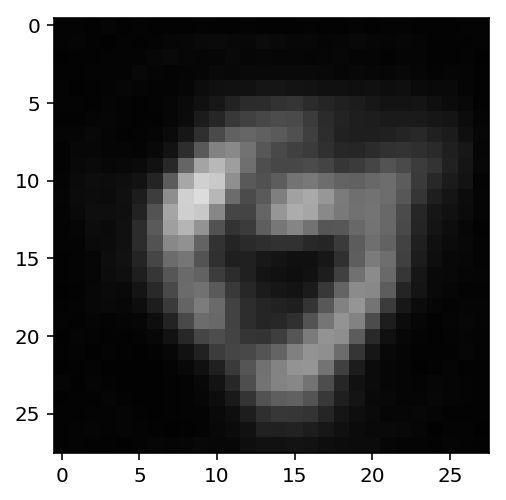

In [57]:
def plot_note(coord=np.arange(100), p=8):
    hilbert_curve = HilbertCurve(p, N) #initialize hilbert curve
    
    coords = [coord]
    norm_coords = np.array([[[((coord_x / (2**(p-1)))-1) for coord_x in coord]]  for coord in coords])
    
    #convert coords in hyperspace back to scale [-1,1] (the latent space we're exploring)
    b = torch.tensor(norm_coords).type(torch.FloatTensor).to(device)
    sample = model.decode(b).cpu() #decode norm_coords
    show(make_grid(sample.view(1, 1, 28, 28)))

plot_note(coord=copy_input, p=9)

##  Visualize MNIST of Music Sequence while generating 

In [58]:
def generate_notes_and_visualize(model, init_input, pitchnames, n_vocab):
    """ Generate notes from the neural network based on init_input """
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = init_input 
    prediction_output = []

    # generate 500 notes
    for note_index in range(60):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        index = np.argmax(prediction)
        result = int_to_note[index]
        prediction_output.append(result)

        pattern.append(index)
        pattern = pattern[1:len(pattern)]
        pattern_np = np.asarray(pattern)
        print("Note: ", result)
        plot_note(coord=pattern_np, p=9)

Note len: 59020
Max note int: 358
len(network_input[0]):  100
Note:  E5


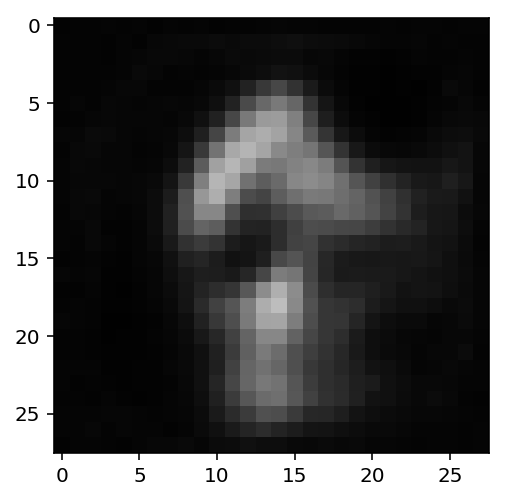

Note:  F5


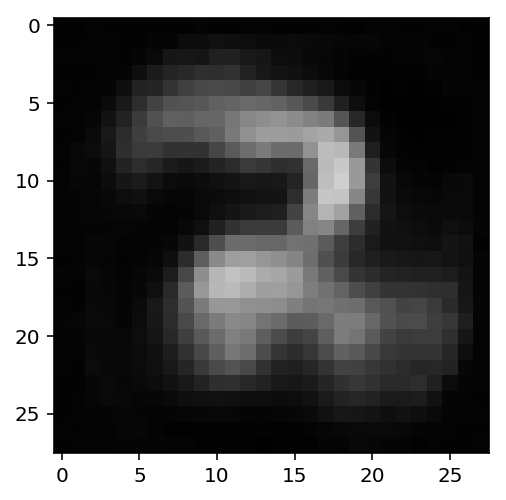

Note:  D2


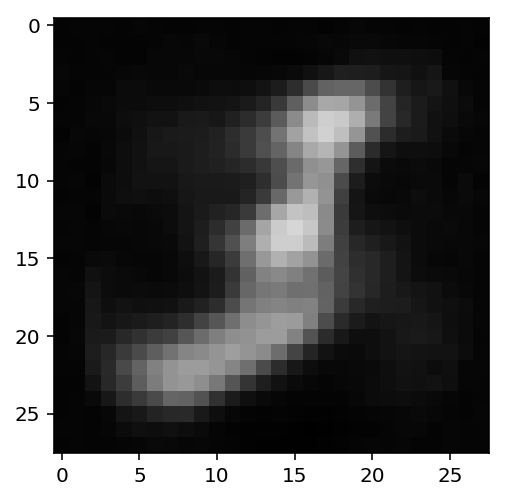

Note:  F2


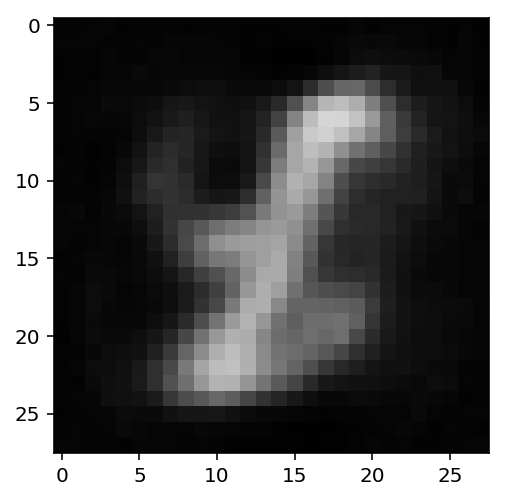

Note:  B-2


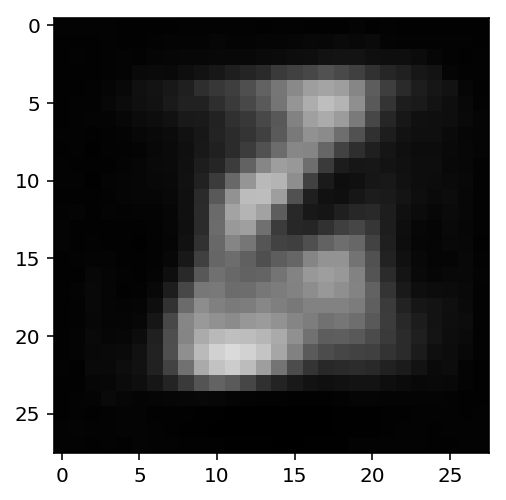

Note:  0.4


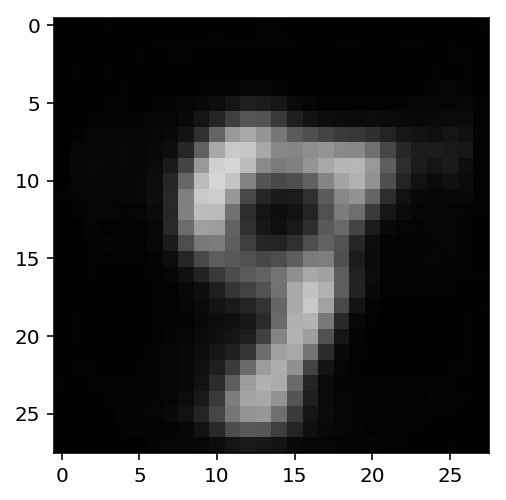

Note:  G2


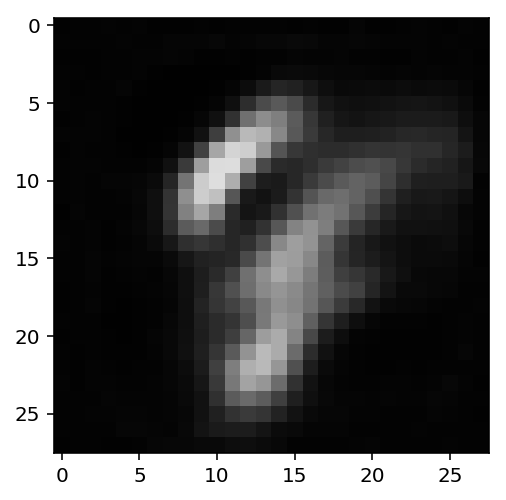

Note:  E5


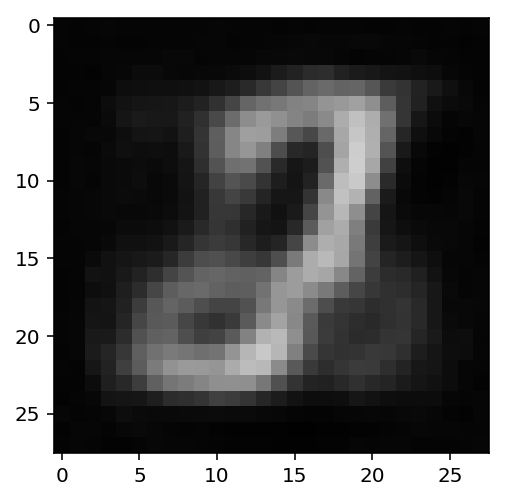

Note:  C5


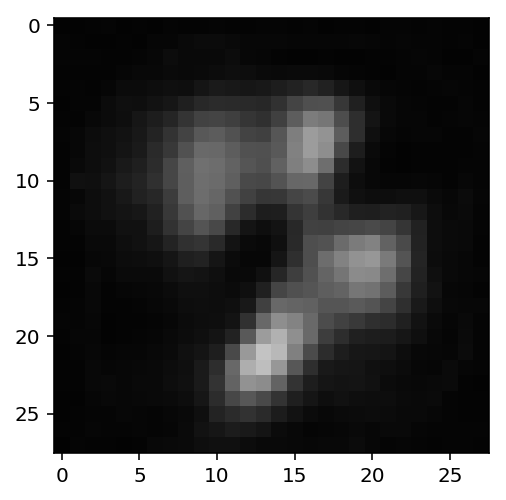

Note:  G#2


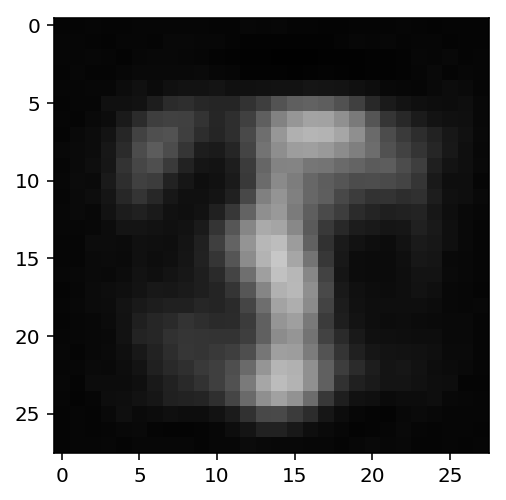

Note:  A4


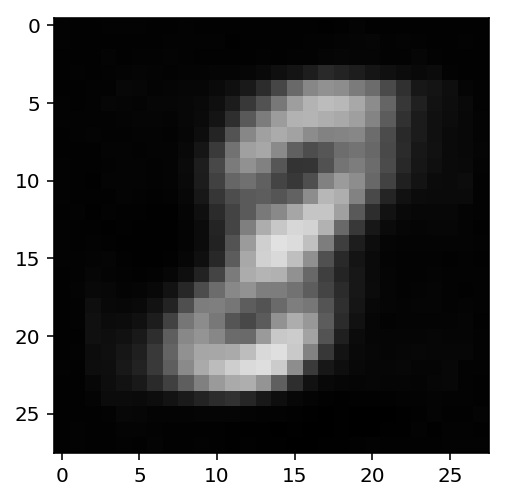

Note:  F#4


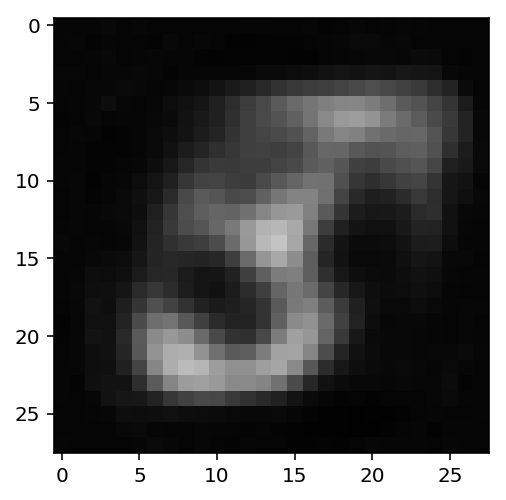

Note:  A2


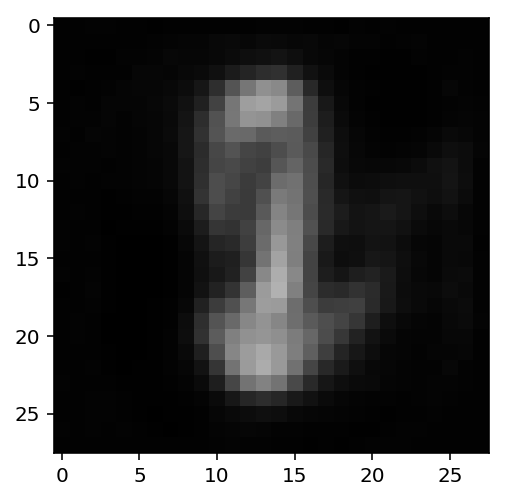

Note:  A4


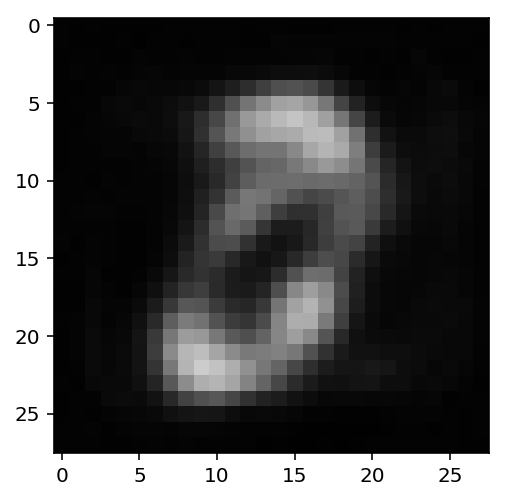

Note:  C5


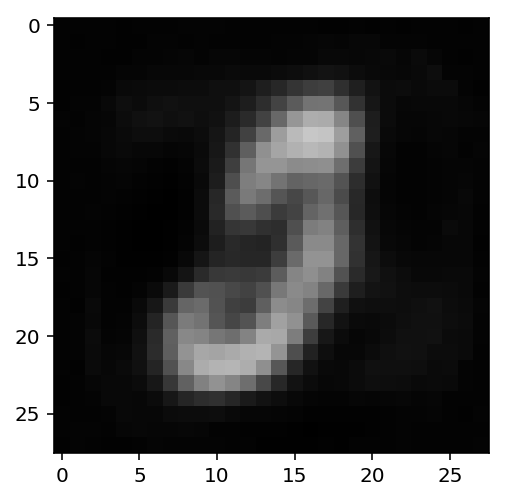

Note:  D2


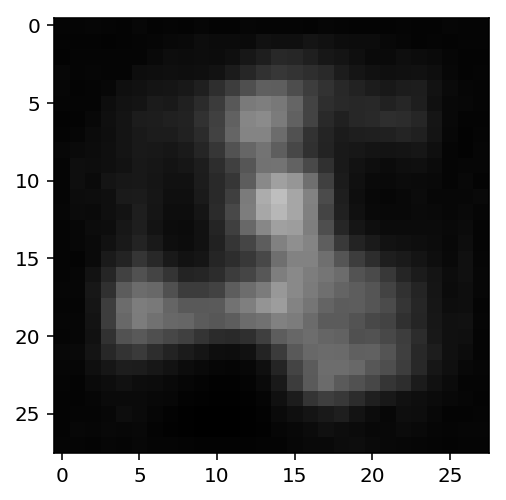

Note:  E5


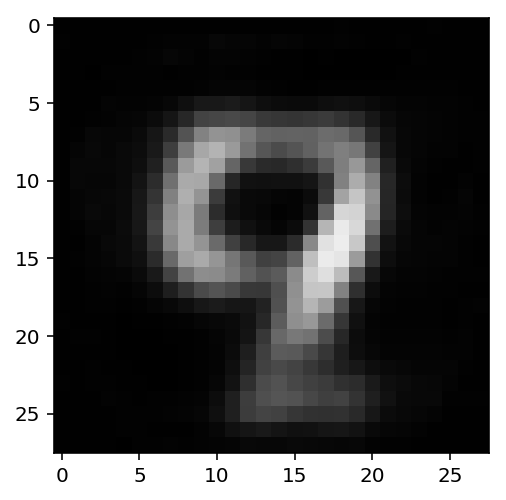

Note:  2.7


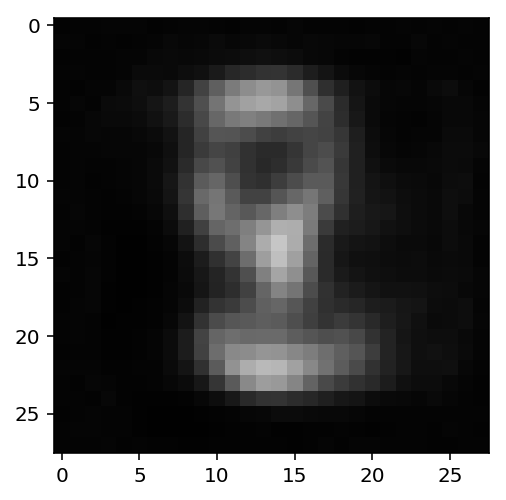

Note:  C#3


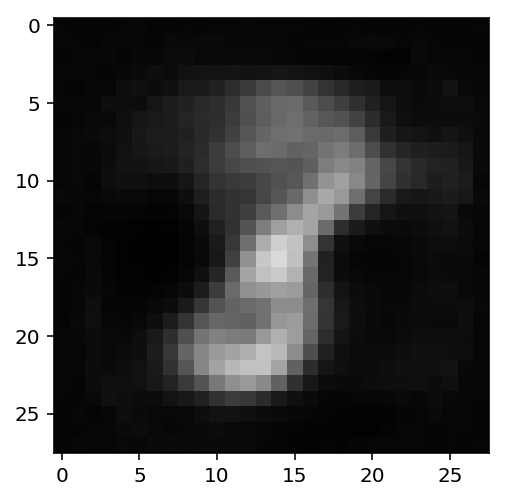

Note:  G5


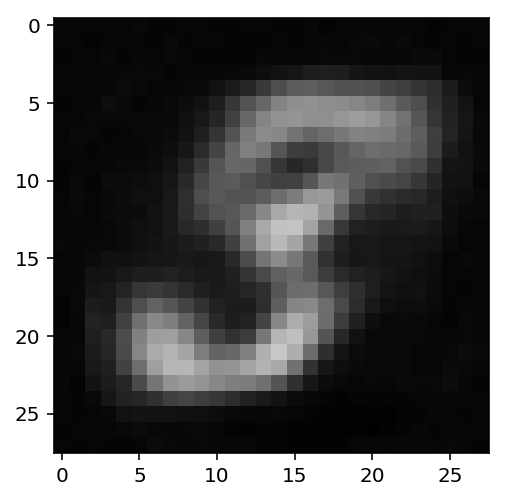

Note:  D3


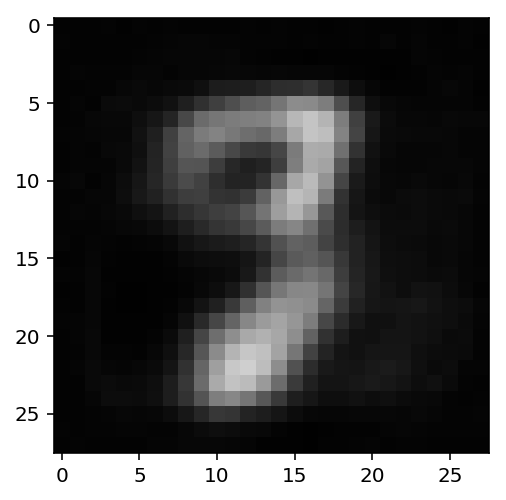

Note:  D5


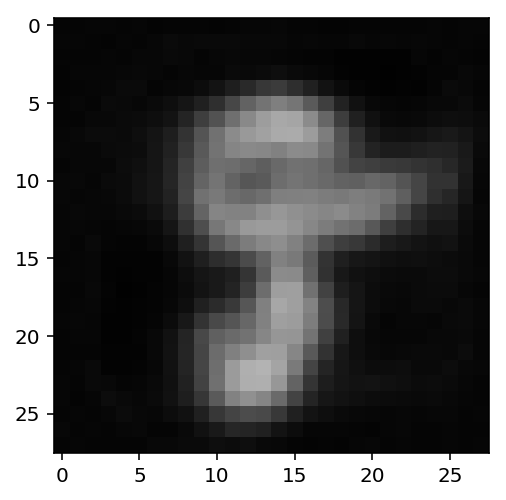

Note:  F3


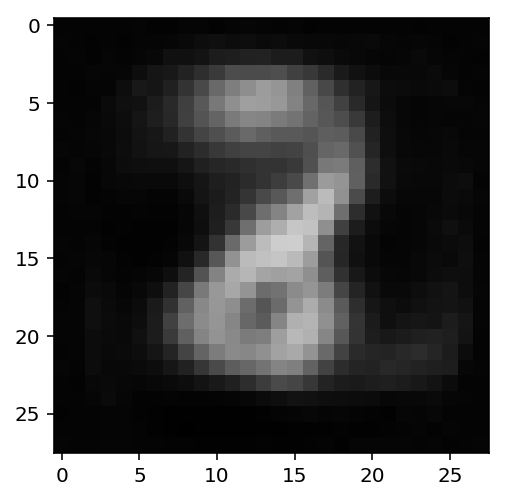

Note:  B2


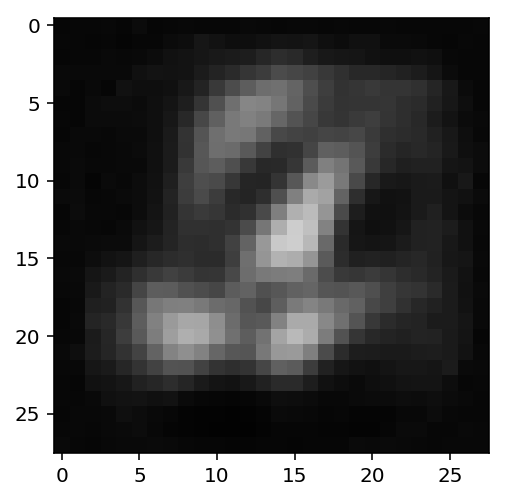

Note:  0


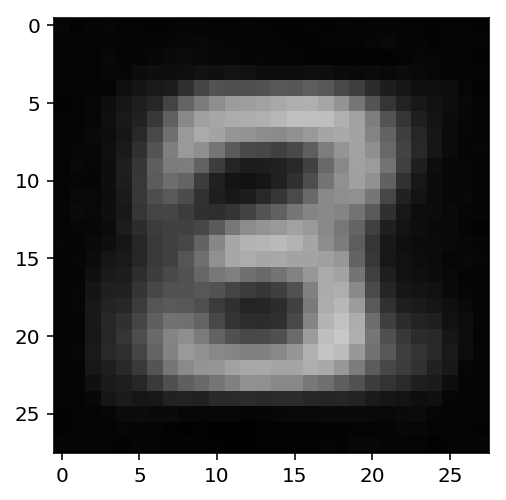

Note:  A2


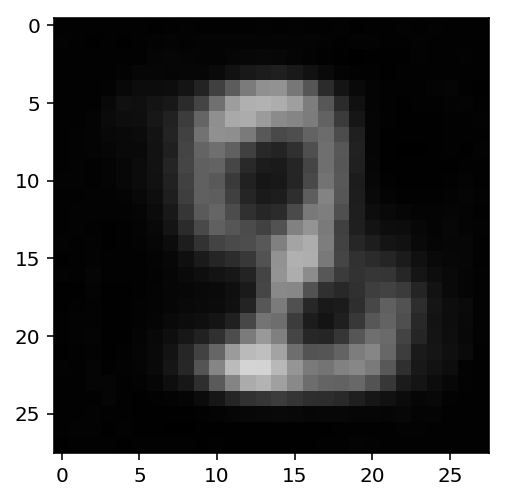

Note:  C5


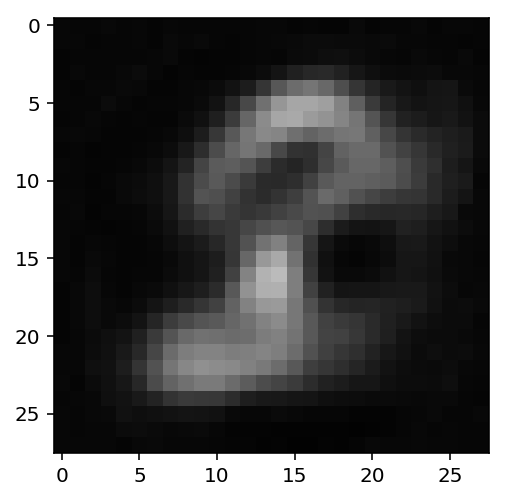

Note:  A4


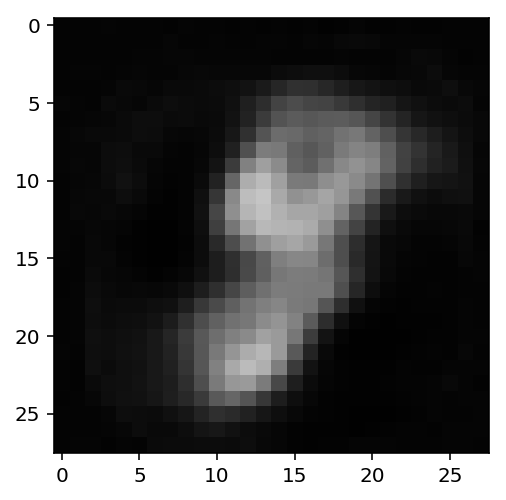

Note:  G2


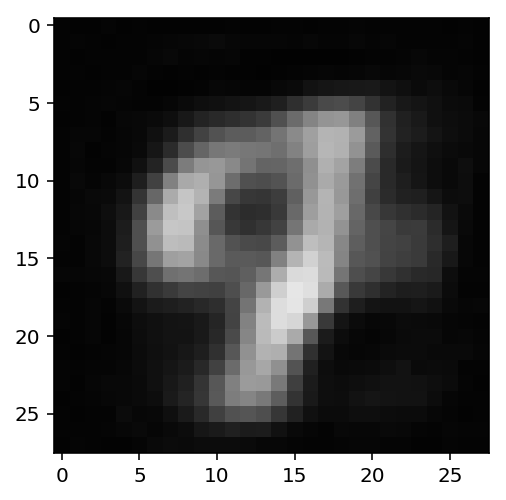

Note:  F#4


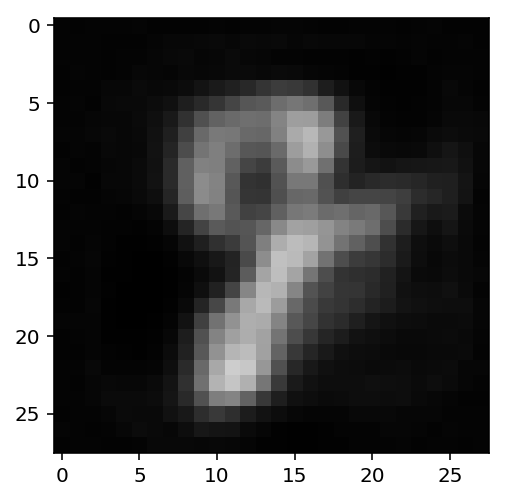

Note:  D4


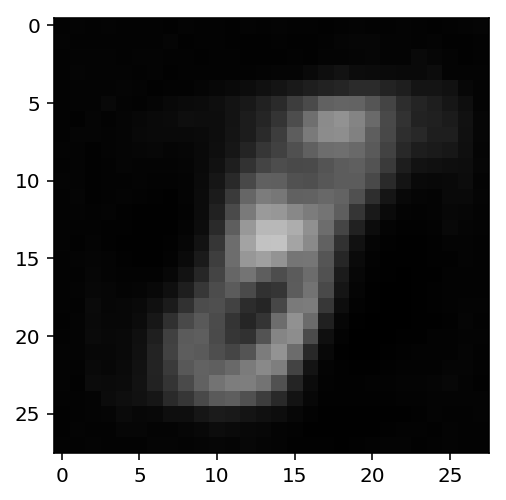

Note:  A2


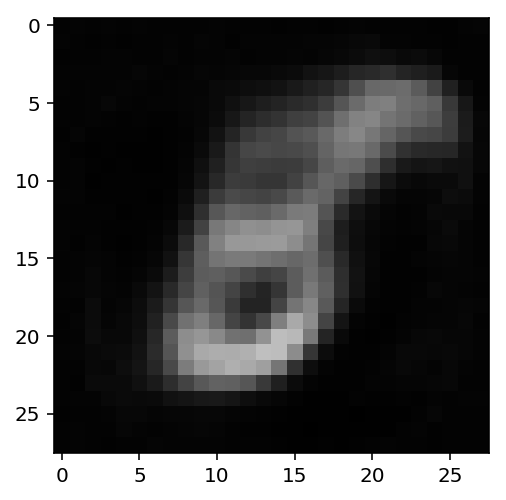

Note:  F#4


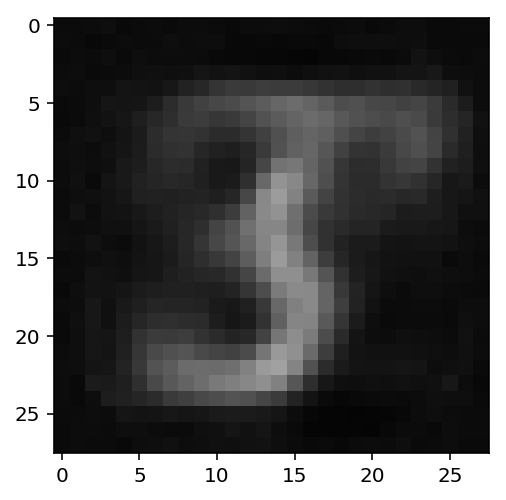

Note:  A4


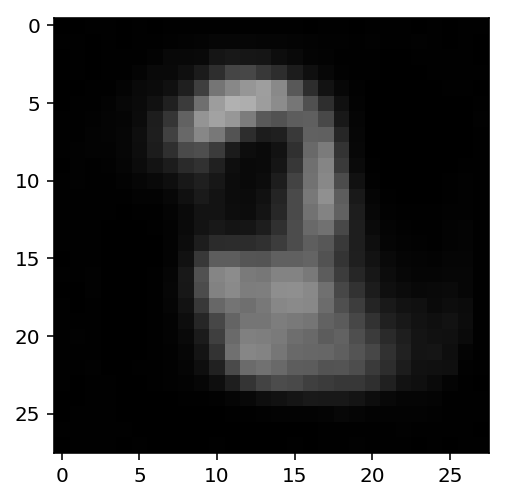

Note:  F#2


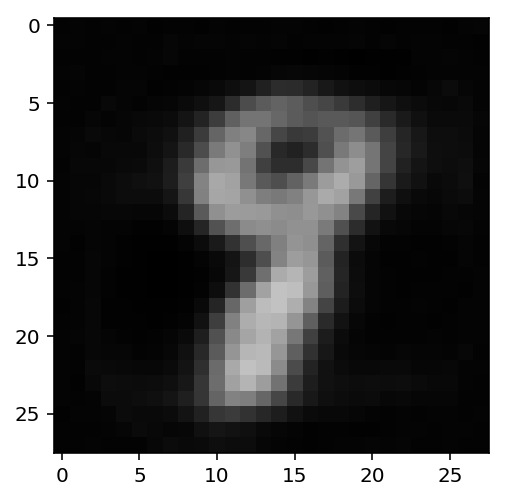

Note:  C5


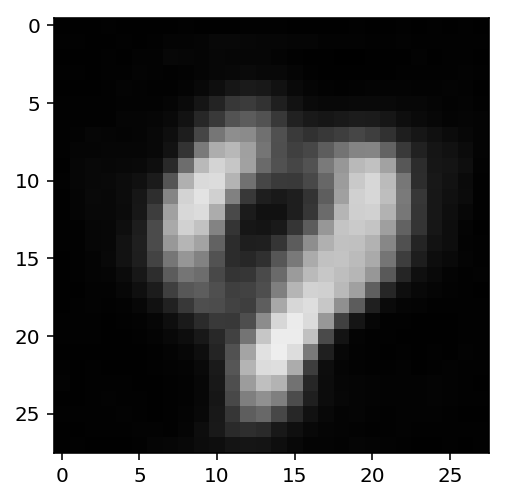

Note:  7.11


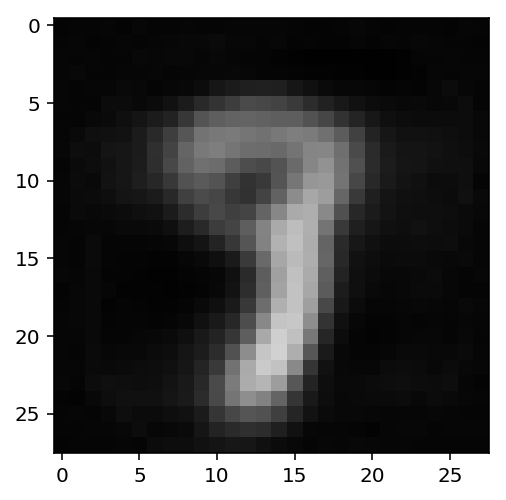

Note:  F3


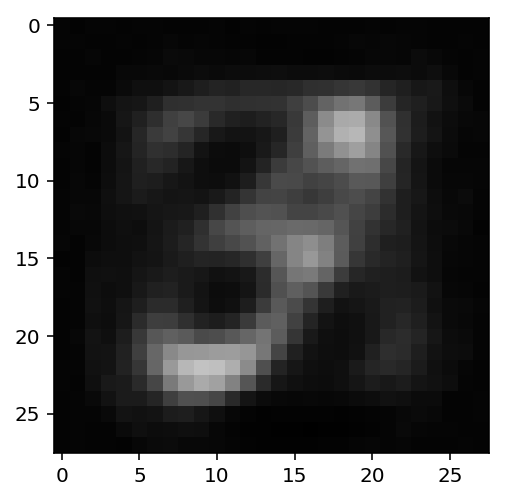

Note:  C5


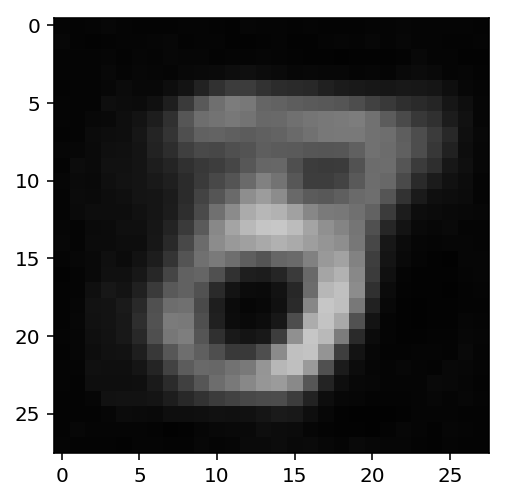

Note:  E3


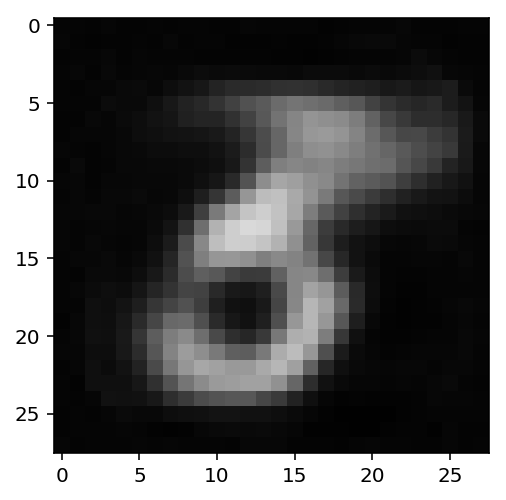

Note:  2


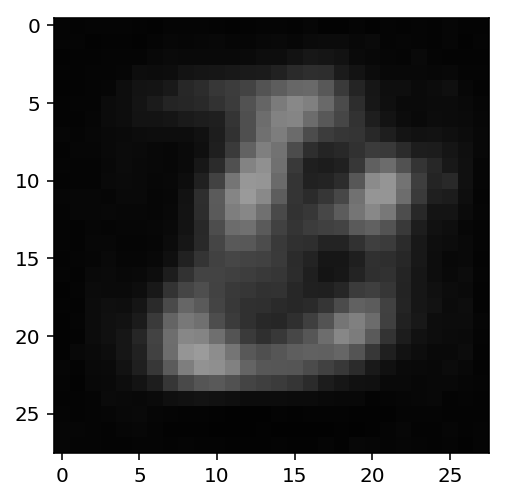

Note:  5.11


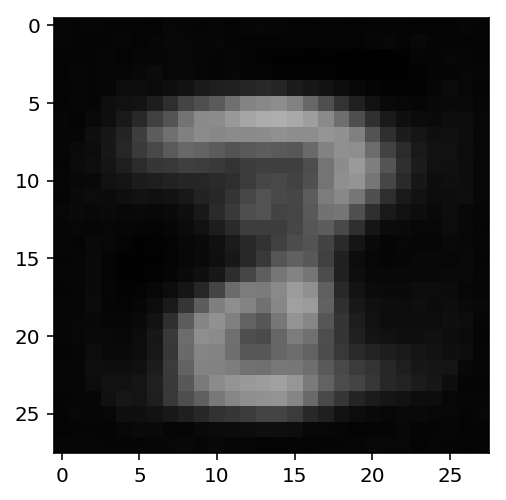

Note:  0.4


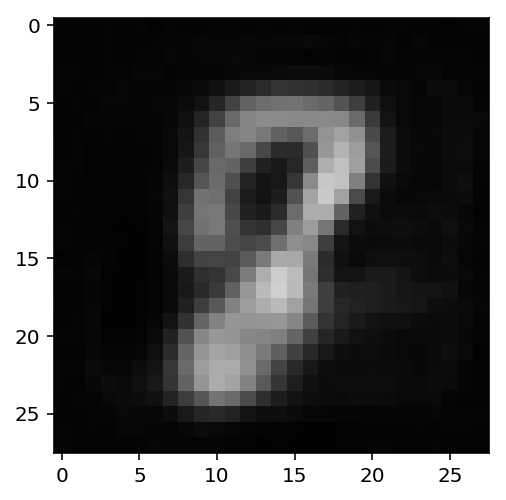

Note:  G2


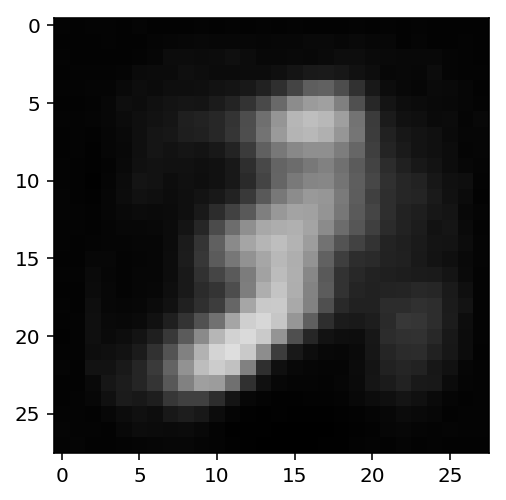

Note:  E5


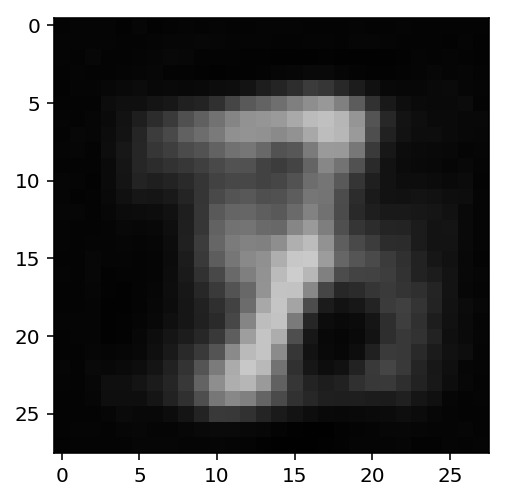

Note:  C5


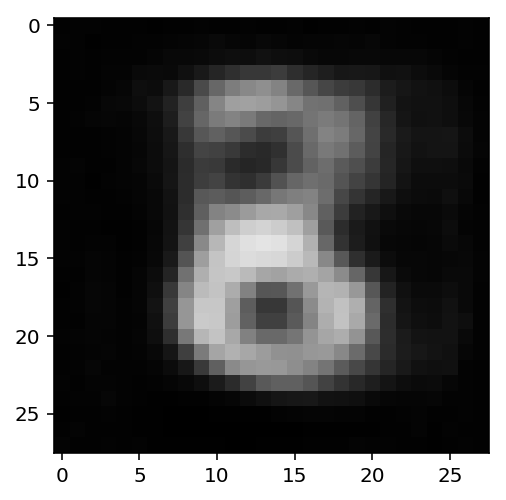

Note:  G#2


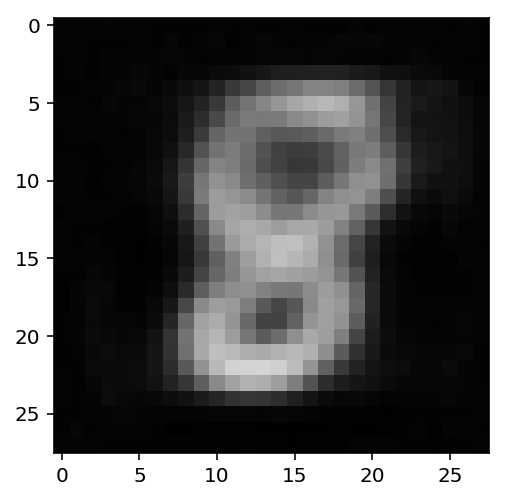

Note:  A4


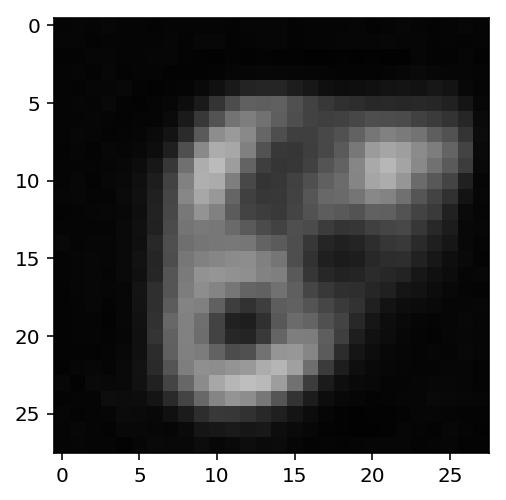

Note:  F#4


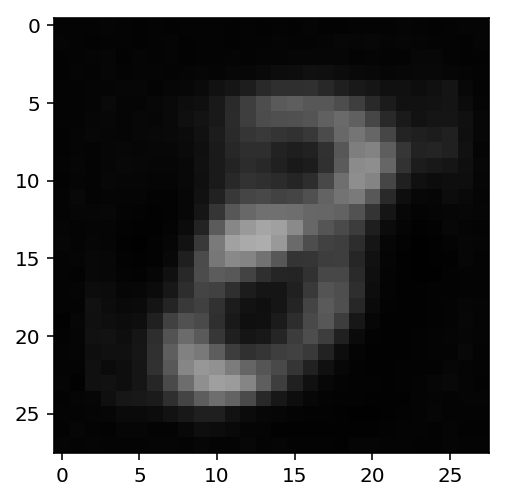

Note:  A2


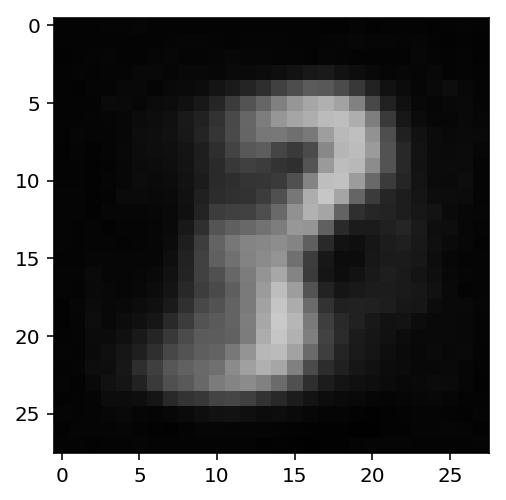

Note:  A4


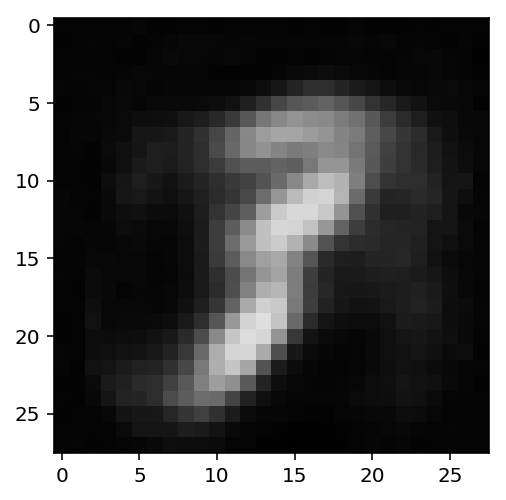

Note:  C5


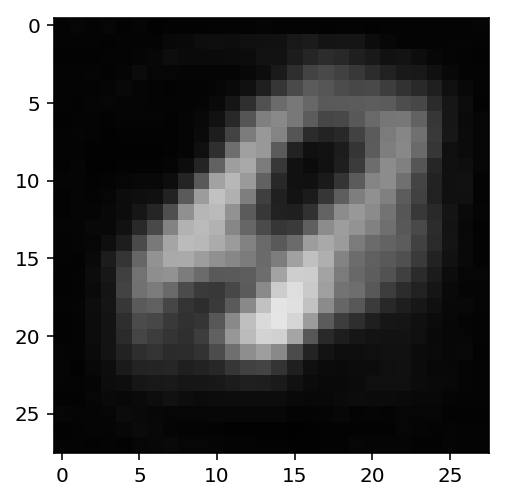

Note:  D2


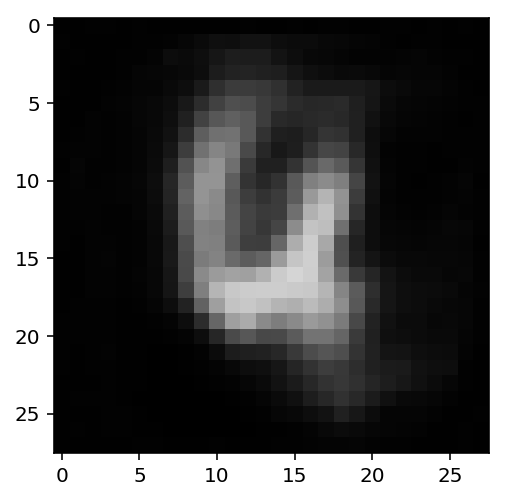

Note:  E5


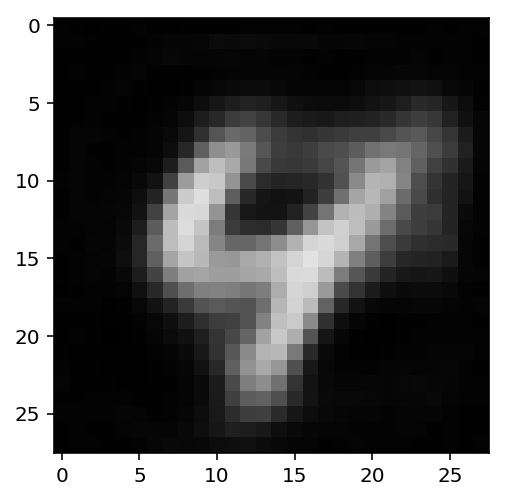

Note:  2.7


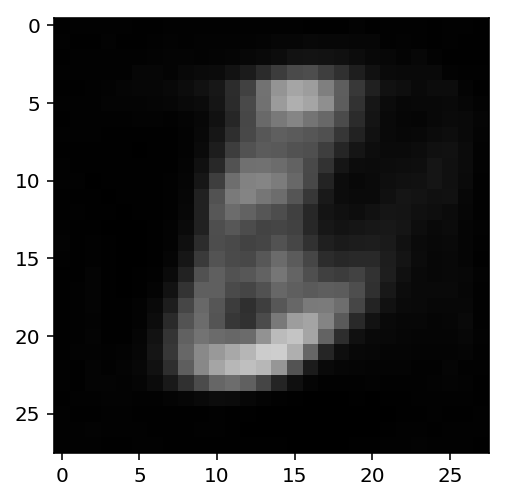

Note:  A2


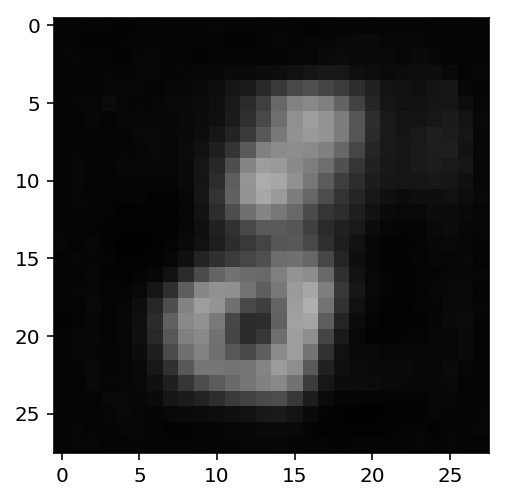

Note:  G5


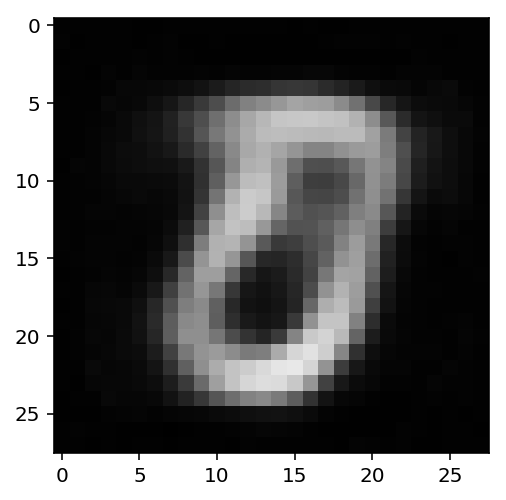

Note:  B-2


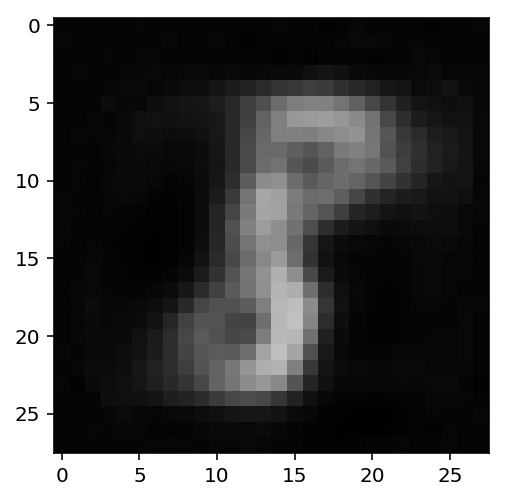

Note:  D5


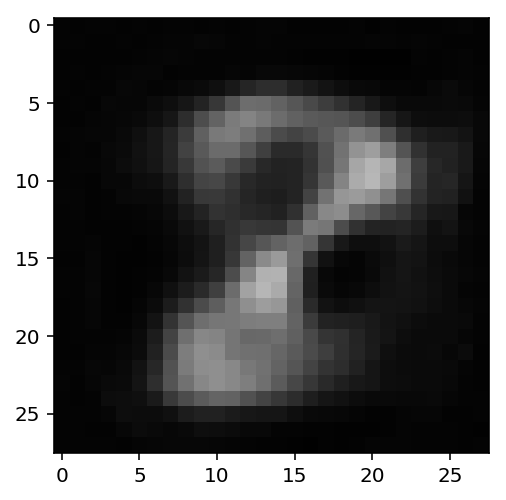

Note:  B2


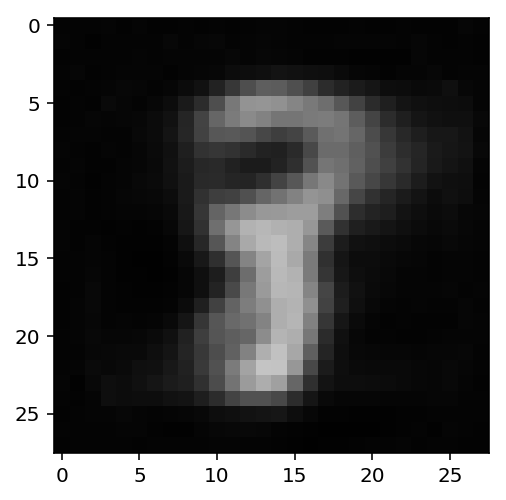

In [53]:
import music_gen_audio as mga
import numpy as np
MODE = "original"
notes, pitchnames, n_vocab, network_input, normalized_input, note_to_int = mga.retrieve_notes_trained_data()
if MODE == "original":
    music_model = mga.create_network_original(normalized_input, n_vocab)
else:
    music_model = mga.create_network_small(normalized_input, n_vocab)
    
# input size is 1xlen(init_input)
# 1 x 101
# Example: [311, 299, 313, 297, 299, 280, 299, 318, 313, 320, 143, 21, 45, 116, 49, 354, 277, 354, 277, 262, 277, 354, 277, 354, 277, 262, 277, 354, 277, 354, 277, 262, 277, 354, 277, 354, 277, 262, 277, 357, 354, 354, 320, 317, 342, 345, 354, 354, 333, 317, 342, 320, 354, 354, 4, 145, 320, 354, 354, 317, 342, 357, 311, 311, 345, 354, 290, 293, 311, 311, 314, 354, 290, 293, 311, 311, 229, 241, 357, 311, 311, 354, 290, 357, 354, 354, 320, 317, 342, 345, 354, 354, 333, 317, 342, 320, 354, 354, 4, 145]

# pick a random sequence from the input as a starting point for the prediction
rand_index = np.random.randint(0, len(network_input)-1)
init_input = network_input[rand_index]
copy_input = np.asarray(init_input)

# predict output from this sequence
prediction_output = generate_notes_and_visualize(music_model, init_input, pitchnames, n_vocab)

In [ ]:
mga.create_midi(prediction_output)